In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd

In [3]:
# This is to load the shape file
shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'

# And project it into EPSG:2263 (NAD 83 NY State) plane
neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))

In [4]:
neighborhoods.head()

STATE    COUNTY                     CITY             NAME  REGIONID  \
0    NY    Monroe                Rochester  Ellwanger-Barry  343894.0   
1    NY  New York  New York City-Manhattan     West Village  270964.0   
2    NY     Kings   New York City-Brooklyn      Bensonhurst  193285.0   
3    NY      Erie                  Buffalo       South Park  270935.0   
4    NY  New York  New York City-Manhattan     East Village  270829.0   

                                            geometry  
0  POLYGON ((19805.35711778845 1099961.05355486, ...  
1  POLYGON ((980372.9910645633 205202.4799663476,...  
2  POLYGON ((978233.4712775955 159030.8800673813,...  
3  POLYGON ((-311815.6157876701 1012190.261676005...  
4  POLYGON ((987758.593831465 206590.82743873, 99...

In [5]:
# We construct an R-Tree by going through the geometries of the
# shapefiles (i.e. the polygons in the 'geomtry' column). We only 
# use the bounds, not the actual geometry, and the key for each 
# bound is the index into the neighborhood name
index = rtree.Rtree()
for idx,geometry in enumerate(neighborhoods.geometry):
    index.insert(idx, geometry.bounds)

In [6]:
# This is the bounding box of all neighborhoods (in NAD 83 projection)
index.bounds

[-331110.02592820046,
 119967.03773856077,
 1067432.6651321745,
 1150191.636787515]

In [19]:
# The code below will go through the greentaxi.csv file, and:
# (1) Select the trips happened between 10a and 11a.
# (2) Map pick-up locations to neighborhoods using the index above
# (3) Count the trips per neighborhood

import csv
import pyproj
import shapely.geometry as geom


proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}
with open('green.csv', 'r') as fi:
    reader = csv.reader(fi)
    print(next(reader)) # Skip the header
    for row in reader:
        print(row)
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10': continue # skip all records != around 10:xx pickup
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            # idx is in the list of shapes that might match
            if neighborhoods.geometry[idx].contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1

['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
['2015-02-01 00:00:00.0', '2015-02-01 00:00:00.0', '40.762928009033203', '-73.933815002441406', '40.812656402587891', '-73.956741333007812']
['2015-02-01 00:00:00.0', '2015-02-01 00:27:52.0', '40.71795654296875', '-73.957534790039062', '40.677581787109375', '-73.912086486816406']
['2015-02-01 00:00:01.0', '2015-02-01 00:18:27.0', '40.715862274169922', '-73.961990356445312', '40.716781616210938', '-74.012161254882812']
['2015-02-01 00:00:02.0', '2015-02-01 00:07:28.0', '40.8265380859375', '-73.943130493164062', '40.808845520019531', '-73.944831848144531']
['2015-02-01 00:00:03.0', '2015-02-01 00:28:27.0', '40.802326202392578', '-73.9503173828125', '40.752830505371094', '-73.977737426757812']
['2015-02-01 00:00:04.0', '2015-02-01 00:09:16.0', '40.788005828857422', '-73.955673217773438', '40.775993347167969', '-73.944053649902344']
['2015-02-01 00:00:06.0', '20

['2015-02-01 00:29:46.0', '2015-02-01 00:40:16.0', '40.690326690673828', '-73.994613647460938', '40.678245544433594', '-73.948524475097656']
['2015-02-01 00:29:46.0', '2015-02-01 00:43:01.0', '40.643199920654297', '-73.975532531738281', '40.675434112548828', '-73.963272094726562']
['2015-02-01 00:29:47.0', '2015-02-01 00:34:38.0', '40.663455963134766', '-73.991195678710938', '40.646625518798828', '-74.005287170410156']
['2015-02-01 00:29:48.0', '2015-02-01 00:33:34.0', '40.716972351074219', '-73.960830688476562', '40.711288452148438', '-73.959640502929688']
['2015-02-01 00:29:49.0', '2015-02-01 00:48:42.0', '40.669940948486328', '-73.988044738769531', '40.738140106201172', '-74.005294799804688']
['2015-02-01 00:29:50.0', '2015-02-01 00:56:31.0', '40.690235137939453', '-73.987083435058594', '40.662696838378906', '-73.907867431640625']
['2015-02-01 00:29:51.0', '2015-02-01 00:43:50.0', '40.746803283691406', '-73.952812194824219', '40.754608154296875', '-73.914840698242188']
['2015-02-01 

['2015-02-01 01:10:00.0', '2015-02-01 01:24:31.0', '40.746158599853516', '-73.90350341796875', '40.750240325927734', '-73.860145568847656']
['2015-02-01 01:10:02.0', '2015-02-01 01:31:17.0', '40.732292175292969', '-73.954689025878906', '40.728122711181641', '-73.985031127929688']
['2015-02-01 01:10:03.0', '2015-02-01 01:14:07.0', '40.67413330078125', '-73.956764221191406', '40.675411224365234', '-73.947158813476562']
['2015-02-01 01:10:03.0', '2015-02-01 01:20:55.0', '40.744377136230469', '-73.911628723144531', '40.762042999267578', '-73.925796508789062']
['2015-02-01 01:10:03.0', '2015-02-01 01:23:27.0', '40.75927734375', '-73.919639587402344', '40.745342254638672', '-73.95721435546875']
['2015-02-01 01:10:03.0', '2015-02-01 01:27:29.0', '40.720714569091797', '-73.959274291992188', '40.666358947753906', '-73.982208251953125']
['2015-02-01 01:10:04.0', '2015-02-01 01:22:17.0', '40.721588134765625', '-73.845001220703125', '40.734413146972656', '-73.824172973632812']
['2015-02-01 01:10:0

['2015-02-01 01:56:54.0', '2015-02-01 02:02:25.0', '40.746463775634766', '-73.89080810546875', '40.735893249511719', '-73.897872924804688']
['2015-02-01 01:56:54.0', '2015-02-01 02:13:18.0', '40.723846435546875', '-73.950675964355469', '40.773746490478516', '-73.960014343261719']
['2015-02-01 01:56:55.0', '2015-02-01 02:03:20.0', '40.721061706542969', '-73.844314575195312', '40.730026245117188', '-73.857009887695312']
['2015-02-01 01:56:56.0', '2015-02-01 02:09:39.0', '40.713935852050781', '-73.949317932128906', '40.721950531005859', '-73.989341735839844']
['2015-02-01 01:56:56.0', '2015-02-01 02:17:56.0', '40.713985443115234', '-73.95166015625', '40.773773193359375', '-73.951736450195312']
['2015-02-01 01:56:58.0', '2015-02-01 01:58:44.0', '40.746471405029297', '-73.890724182128906', '40.74542236328125', '-73.884124755859375']
['2015-02-01 01:57:01.0', '2015-02-01 02:32:40.0', '40.715538024902344', '-73.960174560546875', '40.791061401367188', '-73.9732666015625']
['2015-02-01 01:57:02

['2015-02-01 03:01:02.0', '2015-02-01 03:08:05.0', '40.663284301757812', '-73.991340637207031', '40.647945404052734', '-74.018119812011719']
['2015-02-01 03:01:02.0', '2015-02-01 03:10:59.0', '40.717403411865234', '-73.958381652832031', '40.693264007568359', '-73.969856262207031']
['2015-02-01 03:01:03.0', '2015-02-01 03:05:29.0', '40.721138000488281', '-73.958564758300781', '40.709030151367188', '-73.966697692871094']
['2015-02-01 03:01:03.0', '2015-02-01 03:14:32.0', '40.718822479248047', '-73.960807800292969', '40.682884216308594', '-73.943794250488281']
['2015-02-01 03:01:05.0', '2015-02-01 03:08:05.0', '40.787876129150391', '-73.94140625', '40.806560516357422', '-73.942184448242188']
['2015-02-01 03:01:07.0', '2015-02-01 03:03:33.0', '40.711257934570312', '-73.947128295898438', '40.714683532714844', '-73.941925048828125']
['2015-02-01 03:01:07.0', '2015-02-01 03:08:10.0', '40.721290588378906', '-73.844085693359375', '40.715038299560547', '-73.8114013671875']
['2015-02-01 03:01:07.

['2015-02-01 04:20:37.0', '2015-02-01 04:26:01.0', '40.714042663574219', '-73.951606750488281', '40.722682952880859', '-73.948356628417969']
['2015-02-01 04:20:39.0', '2015-02-01 04:22:34.0', '40.685813903808594', '-73.915771484375', '40.681293487548828', '-73.916862487792969']
['2015-02-01 04:20:39.0', '2015-02-01 04:28:18.0', '40.7130126953125', '-73.966224670410156', '40.7220458984375', '-73.949752807617188']
['2015-02-01 04:20:41.0', '2015-02-01 04:33:37.0', '40.744033813476562', '-73.927925109863281', '40.729328155517578', '-73.85943603515625']
['2015-02-01 04:20:47.0', '2015-02-01 04:29:53.0', '40.760452270507812', '-73.915290832519531', '40.772148132324219', '-73.909767150878906']
['2015-02-01 04:20:49.0', '2015-02-01 04:31:13.0', '40.673286437988281', '-73.989593505859375', '40.668106079101562', '-73.951530456542969']
['2015-02-01 04:20:50.0', '2015-02-01 04:35:50.0', '40.685314178466797', '-73.991355895996094', '40.727226257324219', '-73.983924865722656']
['2015-02-01 04:20:51

['2015-02-01 07:37:38.0', '2015-02-01 07:47:52.0', '40.821117401123047', '-73.939666748046875', '40.786121368408203', '-73.953025817871094']
['2015-02-01 07:37:39.0', '2015-02-01 07:51:55.0', '40.728004455566406', '-73.953224182128906', '40.673946380615234', '-73.95587158203125']
['2015-02-01 07:37:46.0', '2015-02-01 07:59:01.0', '40.638748168945312', '-73.904159545898438', '40.686531066894531', '-73.975318908691406']
['2015-02-01 07:37:47.0', '2015-02-01 07:53:36.0', '40.761749267578125', '-73.925491333007812', '40.77105712890625', '-73.979789733886719']
['2015-02-01 07:37:49.0', '2015-02-01 07:46:06.0', '40.826404571533203', '-73.950653076171875', '40.804458618164062', '-73.937820434570312']
['2015-02-01 07:37:51.0', '2015-02-01 07:56:50.0', '40.686996459960938', '-73.963722229003906', '40.742317199707031', '-74.006805419921875']
['2015-02-01 07:37:52.0', '2015-02-01 07:51:22.0', '40.710342407226562', '-73.963333129882812', '40.738185882568359', '-74.008026123046875']
['2015-02-01 07

['2015-02-01 10:02:12.0', '2015-02-01 10:13:27.0', '40.714107513427734', '-73.951454162597656', '40.713661193847656', '-74.006736755371094']
['2015-02-01 10:02:15.0', '2015-02-01 10:08:39.0', '40.716602325439453', '-73.958930969238281', '40.728672027587891', '-73.958992004394531']
['2015-02-01 10:02:25.0', '2015-02-01 10:10:35.0', '40.800357818603516', '-73.94573974609375', '40.779201507568359', '-73.953582763671875']
['2015-02-01 10:02:28.0', '2015-02-01 10:20:59.0', '40.761772155761719', '-73.925346374511719', '40.694965362548828', '-73.994194030761719']
['2015-02-01 10:02:47.0', '2015-02-01 10:15:40.0', '40.744110107421875', '-73.924980163574219', '40.756385803222656', '-73.976654052734375']
['2015-02-01 10:02:48.0', '2015-02-01 10:05:53.0', '40.795780181884766', '-73.941429138183594', '40.795551300048828', '-73.932182312011719']
['2015-02-01 10:02:55.0', '2015-02-01 10:14:55.0', '40.810211181640625', '-73.951423645019531', '40.778079986572266', '-73.974777221679688']
['2015-02-01 1

['2015-02-01 10:06:56.0', '2015-02-01 10:08:38.0', '40.823978424072266', '-73.9521484375', '40.828018188476562', '-73.949134826660156']
['2015-02-01 10:06:59.0', '2015-02-01 10:40:15.0', '40.758701324462891', '-73.9193115234375', '40.726333618164062', '-73.978279113769531']
['2015-02-01 10:07:04.0', '2015-02-01 10:15:14.0', '40.721401214599609', '-73.844284057617188', '40.727703094482422', '-73.856269836425781']
['2015-02-01 10:07:07.0', '2015-02-01 10:40:37.0', '40.694316864013672', '-73.945388793945312', '40.7662353515625', '-73.98980712890625']
['2015-02-01 10:07:14.0', '2015-02-01 10:18:48.0', '40.805408477783203', '-73.962112426757812', '40.778636932373047', '-73.981918334960938']
['2015-02-01 10:07:17.0', '2015-02-01 10:24:39.0', '40.816558837890625', '-73.907669067382812', '40.775398254394531', '-73.94793701171875']
['2015-02-01 10:07:17.0', '2015-02-01 10:22:32.0', '40.790775299072266', '-73.953582763671875', '40.749454498291016', '-73.991439819335938']
['2015-02-01 10:07:19.0'

['2015-02-01 10:16:24.0', '2015-02-01 10:17:49.0', '40.800006866455078', '-73.940704345703125', '40.792533874511719', '-73.946098327636719']
['2015-02-01 10:16:24.0', '2015-02-01 10:48:34.0', '40.668655395507812', '-73.994026184082031', '40.775543212890625', '-73.962760925292969']
['2015-02-01 10:16:27.0', '2015-02-01 10:18:30.0', '40.806800842285156', '-73.946311950683594', '40.79931640625', '-73.954971313476562']
['2015-02-01 10:16:28.0', '2015-02-01 10:21:10.0', '40.676151275634766', '-73.980636596679688', '40.668125152587891', '-73.990623474121094']
['2015-02-01 10:16:34.0', '2015-02-01 10:21:53.0', '40.802040100097656', '-73.943367004394531', '40.8189697265625', '-73.940994262695312']
['2015-02-01 10:16:36.0', '2015-02-01 10:23:11.0', '40.805438995361328', '-73.96209716796875', '40.7843017578125', '-73.973876953125']
['2015-02-01 10:16:36.0', '2015-02-01 10:51:48.0', '40.671993255615234', '-73.963508605957031', '40.754768371582031', '-73.982551574707031']
['2015-02-01 10:16:40.0',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['2015-02-01 12:54:38.0', '2015-02-01 13:09:56.0', '40.759544372558594', '-73.830421447753906', '40.770786285400391', '-73.797142028808594']
['2015-02-01 12:54:38.0', '2015-02-01 13:11:33.0', '40.809528350830078', '-73.951591491699219', '40.769565582275391', '-73.960372924804688']
['2015-02-01 12:54:38.0', '2015-02-01 12:54:50.0', '40.874721527099609', '-73.911659240722656', '40.874729156494141', '-73.911651611328125']
['2015-02-01 12:54:39.0', '2015-02-01 13:02:19.0', '0.0', '0.0', '40.683567047119141', '-73.935371398925781']
['2015-02-01 12:54:41.0', '2015-02-01 13:12:28.0', '40.733928680419922', '-73.870750427246094', '40.707069396972656', '-73.835044860839844']
['2015-02-01 12:54:41.0', '2015-02-01 12:57:44.0', '40.817028045654297', '-73.938514709472656', '40.82611083984375', '-73.93560791015625']
['2015-02-01 12:54:47.0', '2015-02-01 12:57:07.0', '40.803695678710938', '-73.963180541992188', '40.810737609863281', '-73.962074279785156']
['2015-02-01 12:54:48.0', '2015-02-01 13:05:5

['2015-02-01 14:15:25.0', '2015-02-01 14:23:05.0', '40.719009399414062', '-73.960983276367188', '40.722511291503906', '-73.950096130371094']
['2015-02-01 14:15:25.0', '2015-02-01 14:21:34.0', '40.747161865234375', '-73.887779235839844', '40.754245758056641', '-73.885093688964844']
['2015-02-01 14:15:25.0', '2015-02-01 14:15:54.0', '40.684940338134766', '-73.935989379882812', '40.685150146484375', '-73.933990478515625']
['2015-02-01 14:15:26.0', '2015-02-01 14:27:13.0', '40.798652648925781', '-73.941810607910156', '40.818443298339844', '-73.914260864257812']
['2015-02-01 14:15:28.0', '2015-02-01 14:25:32.0', '40.682243347167969', '-73.979667663574219', '40.722980499267578', '-73.988845825195312']
['2015-02-01 14:15:29.0', '2015-02-01 14:49:41.0', '40.808094024658203', '-73.9527587890625', '40.707744598388672', '-74.012405395507812']
['2015-02-01 14:15:31.0', '2015-02-01 14:19:49.0', '40.630855560302734', '-74.008773803710938', '40.625938415527344', '-74.006332397460938']
['2015-02-01 14

['2015-02-01 15:35:06.0', '2015-02-01 15:45:51.0', '40.689571380615234', '-73.992271423339844', '40.678096771240234', '-73.94451904296875']
['2015-02-01 15:35:08.0', '2015-02-01 15:43:27.0', '40.681854248046875', '-73.958847045898438', '40.678012847900391', '-73.973152160644531']
['2015-02-01 15:35:08.0', '2015-02-01 15:45:08.0', '40.798152923583984', '-73.940406799316406', '40.797401428222656', '-73.962570190429688']
['2015-02-01 15:35:08.0', '2015-02-01 15:45:31.0', '40.847988128662109', '-73.937995910644531', '40.795818328857422', '-73.969924926757812']
['2015-02-01 15:35:10.0', '2015-02-01 15:46:21.0', '40.668983459472656', '-73.979759216308594', '40.634193420410156', '-73.969955444335938']
['2015-02-01 15:35:10.0', '2015-02-01 15:51:20.0', '40.746845245361328', '-73.890892028808594', '40.750900268554688', '-73.870460510253906']
['2015-02-01 15:35:11.0', '2015-02-01 16:03:25.0', '40.71673583984375', '-73.958854675292969', '40.657390594482422', '-73.980827331542969']
['2015-02-01 15

['2015-02-01 16:33:09.0', '2015-02-01 16:51:19.0', '40.719940185546875', '-73.955436706542969', '40.755641937255859', '-73.927726745605469']
['2015-02-01 16:33:13.0', '2015-02-01 16:45:30.0', '40.798057556152344', '-73.939811706542969', '40.824062347412109', '-73.917503356933594']
['2015-02-01 16:33:16.0', '2015-02-01 16:42:21.0', '40.683208465576172', '-73.978981018066406', '40.678504943847656', '-73.952995300292969']
['2015-02-01 16:33:16.0', '2015-02-01 17:08:50.0', '40.663398742675781', '-73.958564758300781', '40.774276733398438', '-73.910964965820312']
['2015-02-01 16:33:17.0', '2015-02-01 16:50:30.0', '40.761920928955078', '-73.92535400390625', '40.743583679199219', '-73.884254455566406']
['2015-02-01 16:33:17.0', '2015-02-01 16:37:51.0', '40.82684326171875', '-73.943023681640625', '40.817447662353516', '-73.939094543457031']
['2015-02-01 16:33:18.0', '2015-02-01 16:40:49.0', '40.784378051757812', '-73.947509765625', '40.803886413574219', '-73.936111450195312']
['2015-02-01 16:33

['2015-02-01 17:26:27.0', '2015-02-01 17:41:46.0', '40.693870544433594', '-73.963005065917969', '40.717380523681641', '-74.001358032226562']
['2015-02-01 17:26:30.0', '2015-02-01 17:34:52.0', '40.714412689208984', '-73.944427490234375', '40.705242156982422', '-73.9276123046875']
['2015-02-01 17:26:30.0', '2015-02-01 17:59:12.0', '40.688625335693359', '-73.956260681152344', '40.688571929931641', '-73.956192016601562']
['2015-02-01 17:26:34.0', '2015-02-01 17:32:07.0', '40.816791534423828', '-73.939002990722656', '40.8045654296875', '-73.955802917480469']
['2015-02-01 17:26:34.0', '2015-02-01 17:43:45.0', '40.841510772705078', '-73.912681579589844', '40.839088439941406', '-73.868270874023438']
['2015-02-01 17:26:36.0', '2015-02-01 17:34:36.0', '40.684650421142578', '-73.977767944335938', '40.696617126464844', '-73.977119445800781']
['2015-02-01 17:26:37.0', '2015-02-01 17:42:14.0', '40.682132720947266', '-73.960281372070312', '40.715690612792969', '-73.964492797851562']
['2015-02-01 17:2

['2015-02-01 18:13:18.0', '2015-02-01 18:22:45.0', '40.695106506347656', '-73.952560424804688', '40.683147430419922', '-73.973541259765625']
['2015-02-01 18:13:18.0', '2015-02-01 18:22:13.0', '40.721397399902344', '-73.844444274902344', '40.703689575195312', '-73.823036193847656']
['2015-02-01 18:13:19.0', '2015-02-01 18:27:30.0', '40.832981109619141', '-73.935615539550781', '40.872734069824219', '-73.904891967773438']
['2015-02-01 18:13:19.0', '2015-02-01 18:16:30.0', '40.807048797607422', '-73.961021423339844', '40.811992645263672', '-73.955223083496094']
['2015-02-01 18:13:22.0', '2015-02-01 18:27:33.0', '40.721012115478516', '-73.844001770019531', '40.743946075439453', '-73.862899780273438']
['2015-02-01 18:13:23.0', '2015-02-01 18:21:56.0', '40.760398864746094', '-73.921249389648438', '40.772090911865234', '-73.913650512695312']
['2015-02-01 18:13:24.0', '2015-02-01 18:27:59.0', '40.705696105957031', '-73.933647155761719', '40.693927764892578', '-73.9619140625']
['2015-02-01 18:13

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



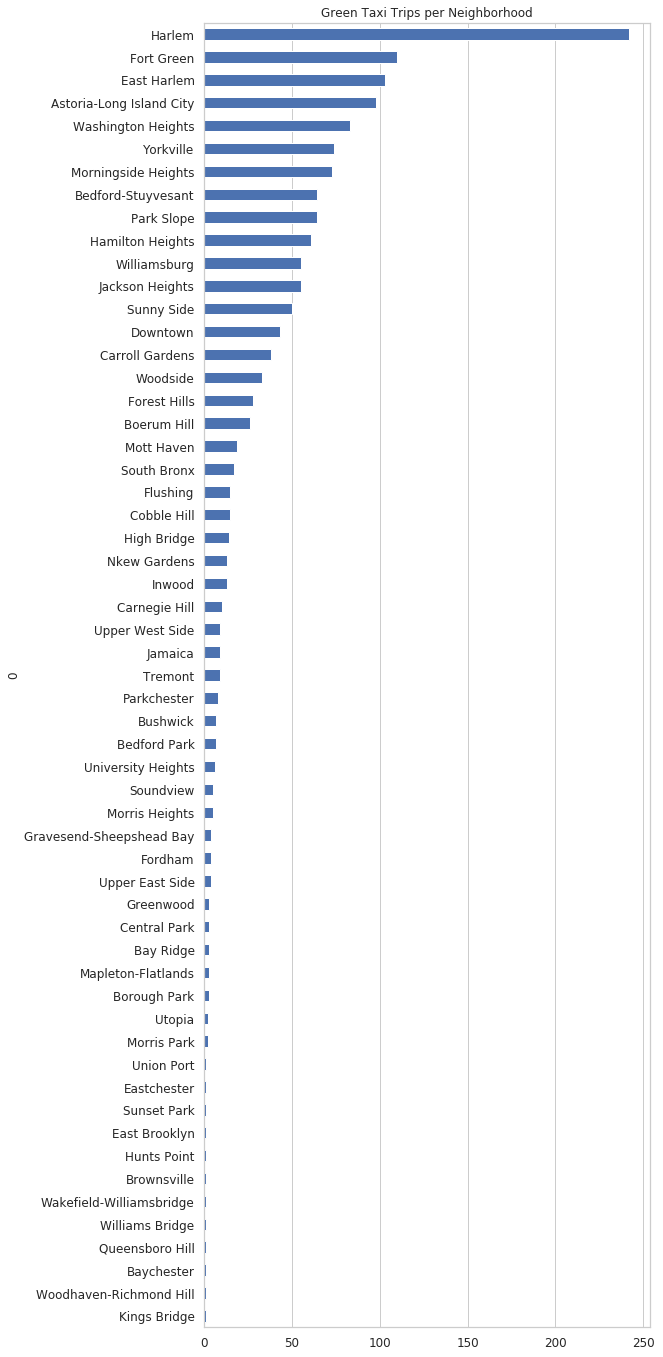

In [8]:
# We create a list consisting of neighborhood names, and counts
countsPerNeighborhood = list(map(
    lambda x: (neighborhoods['NAME'][x[0]], x[1]),
    counts.items()))

# Then we plot using pandas
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Green Taxi Trips per Neighborhood', 
             figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [9]:
# We perform the same task using Spark. Here we run the task in
# parallel on each partition (chunk of data). For each task, we
# have to re-create the R-Tree since the index cannot be shared
# across partitions. Note: we have to import the package inside
# processTrips() to respect the closure property.

def processTrips(pid, records):
    if pid==0:
        next(records)
    counts = {}
    import rtree
    reader = csv.reader(records)
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'
    neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(neighborhoods.geometry):
        index.insert(idx, geometry.bounds)
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            shape = neighborhoods.geometry[idx]
            if shape.contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1
    return counts.items()
            
rdd = sc.textFile('green.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
    .collect()
len(counts)


57

In [2]:
# It's usually better to factor things out for readability

def createIndex(shapefile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findZone(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if zones.geometry[idx].contains(p):
            return idx
    return None

def processTrips(pid, records):
    import csv
    import pyproj
    import shapely.geometry as geom
    
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = createIndex('ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')    
    
    if pid==0:
        next(records)
    reader = csv.reader(records)
    counts = {}
    
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        zone = findZone(p, index, zones)
        if zone:
            counts[zone] = counts.get(zone, 0) + 1
    return counts.items()
            
rdd = sc.textFile('green.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
            .collect()
len(counts)


57

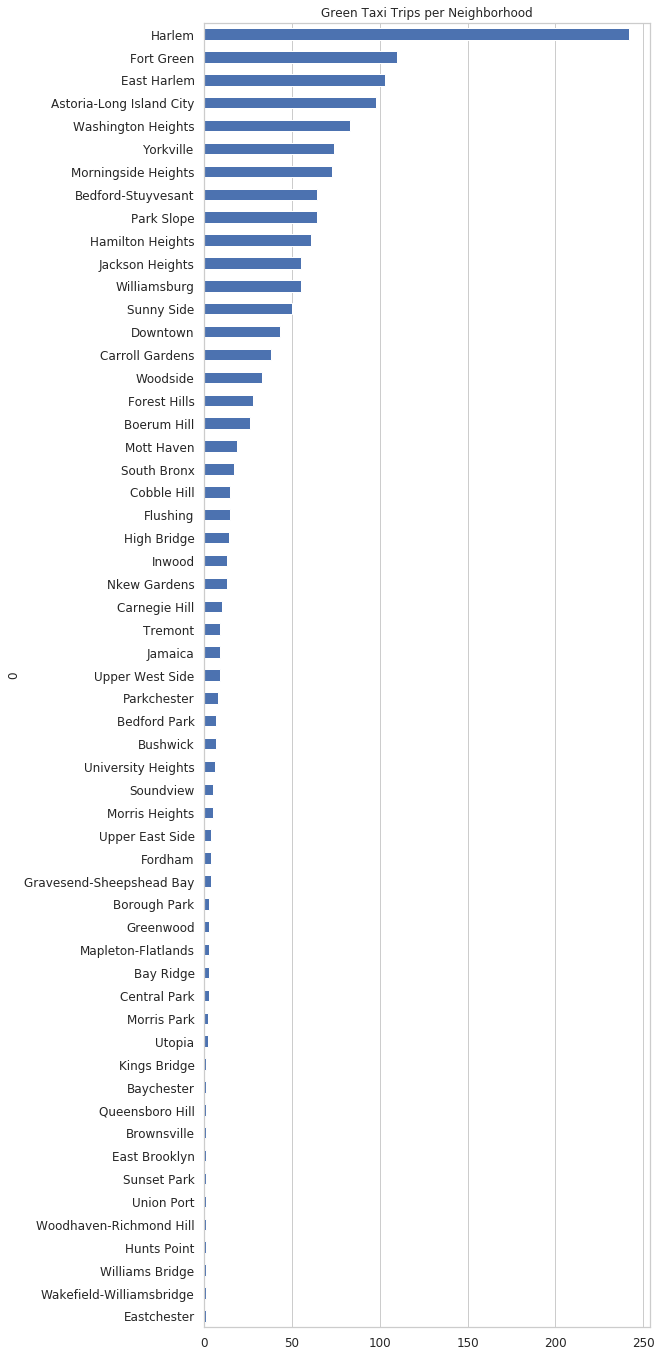

In [11]:
countsPerNeighborhood = list(map(lambda x: (neighborhoods['NAME'][x[0]], x[1]), counts))
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Green Taxi Trips per Neighborhood', figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [27]:
neighborhoods['NAME'][1]

'West Village'